# Aula 6 - Treinamento Machine Learning - FIAP + Alura

## Artificial Intelligence Tools & Examples - Machine Learning - Agrupamento com K-Means em dados de doença coronária

Nesse segundo exemplo vamos a um estudo de caso.

Ref. https://www.kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis/overview

Prof. Dr. Ahirton Lopes (https://github.com/ahirtonlopes)

## Introdução

Segundo a Organização Mundial da Saúde (OMS), as doenças cardíacas são a principal causa de morte no mundo: 13% do total de mortes. É importante diagnosticar e tratar adequadamente pacientes com doenças cardíacas para evitar suas mortes.

Neste notebook, usaremos o conjunto de dados de doenças cardíacas da competição kaggle para treinar um modelo de agrupamento K-Means e tentar prever o grupo de cada paciente com base em suas características ou sintomas. O número ou rótulo dos clusters não foi especificado, portanto, este é um problema de aprendizagem não supervisionado.

Primeiro trabalharemos com o conjunto de dados de modo a limpar, preencher valores nulos e processar os recursos de texto. Em seguida, usaremos este conjunto de dados para treinar um modelo de clustering K-Means. Por fim, tentaremos prever o grupo de cada paciente com base em suas características ou sintomas.

Vamos começar!

In [18]:
from pathlib import Path
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

sns.set_style("whitegrid")

Trabalhar com os pacotes Python certos é crucial ao trabalhar em um projeto de aprendizado de máquina. Os pacotes mais importantes que usaremos são:

- **Polars**: carregamento e processamento de dados
- **Matplotlib, Seaborn**: visualização de dados
- **Scikit-learn**: algoritmos de cluster de aprendizado de máquina
- **Yellobrick**: métricas e visualização de avaliação de aprendizado de máquina

In [19]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Arquivo "{name}" importado pelo usuário com tamanho de {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving heart_disease.csv to heart_disease (1).csv
Arquivo "heart_disease (1).csv" importado pelo usuário com tamanho de 85409 bytes


In [20]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Arquivo "{name}" importado pelo usuário com tamanho de {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving sample.csv to sample.csv
Arquivo "sample.csv" importado pelo usuário com tamanho de 2058 bytes


Para melhorar a legibilidade das colunas do conjunto de dados quando o visualizarmos, usaremos um dicionário para renomear as colunas (`COLUMNS_DICTIONARY`) e uma lista de colunas categóricas (`CATEGORICAL_COLUMNS`) para pré-processar os dados.

In [21]:
# Path to the heart disease dataset file
HEART_DISEASE_FILE_PATH = Path("heart_disease.csv")
HEART_DISEASE_SAMPLE = Path("sample.csv")

# Dictionary to rename columns to improve readability
COLUMNS_DICTIONARY = {
    "sex": "sex",
    "cp": "chest_pain_type",
    "trestbps": "resting_blood_pressure",
    "chol": "cholesterol",
    "fbs": "fasting_blood_sugar",
    "restecg": "resting_electrocardiogram",
    "thalch": "maximum_heart_rate",
    "exang": "exercise_angina",
    "oldpeak": "exercise_st",
    "slope": "slope_st",
    "ca": "n_major_vessels",
    "thal": "thalassemia",
}
CATEGORICAL_COLUMNS = [
    "sex",
    "chest_pain_type",
    "resting_electrocardiogram",
    "slope_st",
    "thalassemia",
]
RANDOM_STATE = 1506
CMAP = sns.diverging_palette(230, 20, n=4)

sns.set_palette(CMAP)

## Análise de Dados e Pré Processamento

Trabalhar com `Polars` ou `Pandas` não faria diferença ao carregar este conjunto de dados devido ao tamanho do arquivo. No entanto, se trabalharmos com conjuntos de dados maiores, `Polars` é mais eficiente e rápido que `Pandas`.

In [22]:
# Dataframe with heart disease raw data
df_heart = (
    pl.scan_csv(HEART_DISEASE_FILE_PATH)
    .drop(["id", "dataset"])
    .rename(COLUMNS_DICTIONARY)
    .collect()
)

In [23]:
df_heart.shape

(920, 13)

É possível que algumas das colunas tenham valores nulos que precisam ser removidos ou preenchidos para usar o conjunto de dados para clustering k-means.

In [24]:
list_columns = df_heart.columns
dtypes = df_heart.dtypes
null_count = df_heart.null_count()
nulls = (
    null_count.transpose()
    .with_columns(
        [
            pl.Series(values=list_columns, name="column_name"),
            pl.Series(values=dtypes, name="dtype"),
        ]
    )
    .rename({"column_0": "null_count"})
    .select(["column_name", "dtype", "null_count"])
    .filter(pl.col("null_count") > 0)
    .with_columns()
    .sort(by=pl.col("null_count"), descending=True)
)
# Get the columns with null values
null_columns = nulls["column_name"].to_list()
nulls

column_name,dtype,null_count
str,object,u32
"""n_major_vessels""",Float64,611
"""thalassemia""",String,486
"""slope_st""",String,309
"""fasting_blood_sugar""",Boolean,90
"""exercise_st""",Float64,62
"""resting_blood_pressure""",Float64,59
"""maximum_heart_rate""",Float64,55
"""exercise_angina""",Boolean,55
"""cholesterol""",Float64,30


A coluna que possui mais valores nulos é `n_major_vessels` (`ca` no conjunto de dados original). Esta coluna possui 611 linhas com valores nulos. Eliminar todas essas linhas afetaria os resultados do clustering, já que isso representa 66,41% dos dados. A próxima coluna é `talassemia` (`thal` no conjunto de dados original) com 486 linhas de valor nulo.

É claro que a eliminação de todos os valores nulos afetaria os resultados do agrupamento e precisamos preencher os valores ausentes.

Encontrar a estratégia adequada para preencher os valores faltantes é difícil e não está claro qual estratégia seria a melhor. Vamos explorar essas colunas para ver se conseguimos encontrar uma dica para a melhor estratégia:

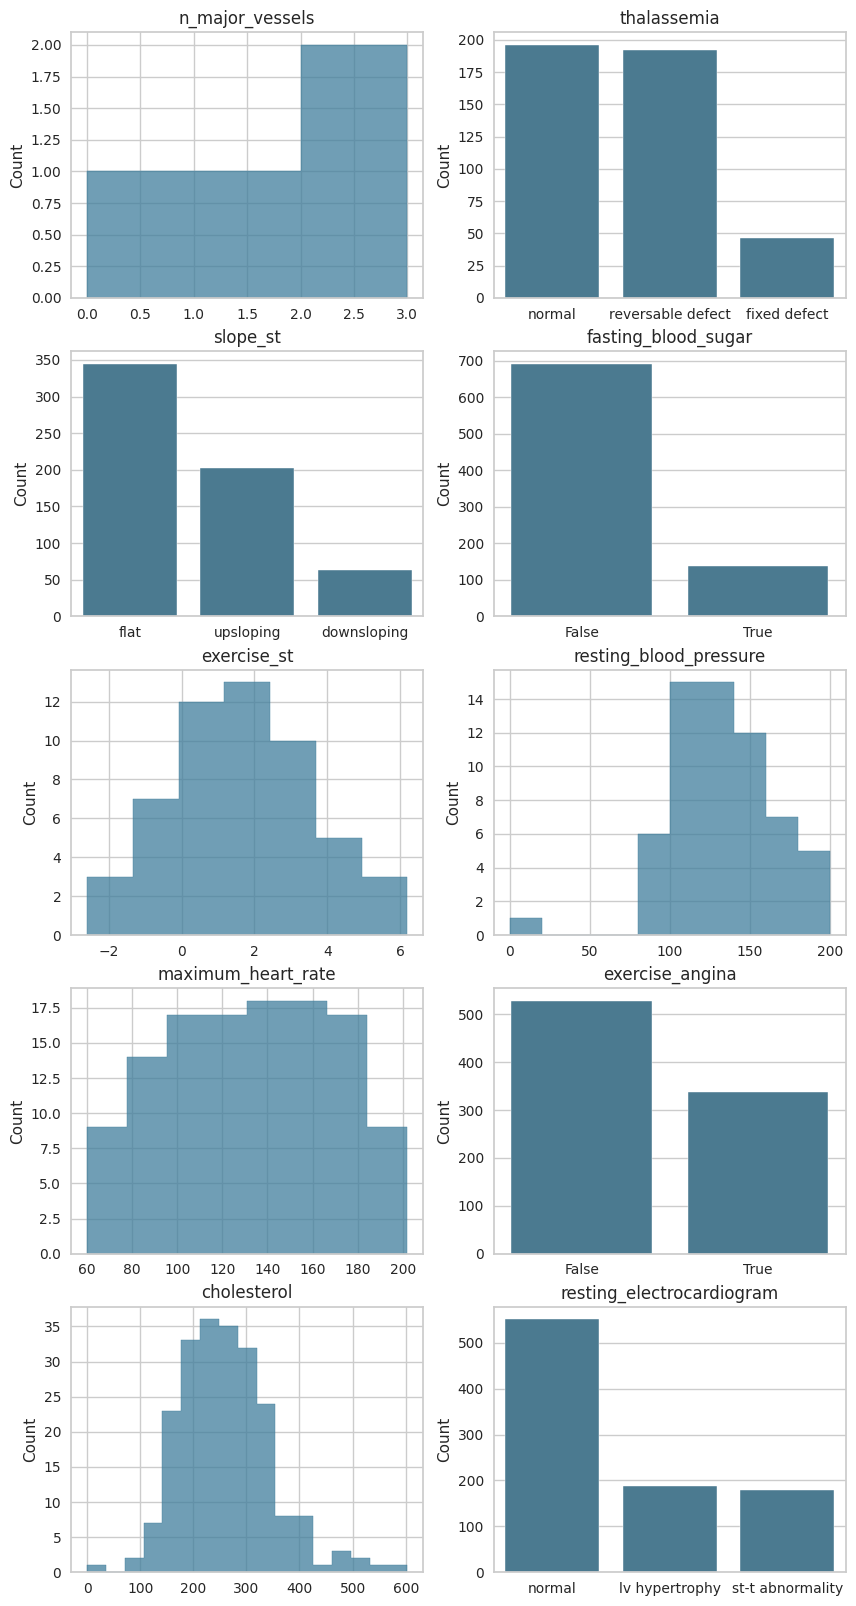

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 20))

pd_heart = df_heart.to_pandas()
for i, name_col in enumerate(null_columns):
    n_col = i % 2
    n_row = i // 2

    counts = pd_heart[name_col].value_counts().reset_index()

    ax[n_row, n_col].set_title(name_col)
    if (
        name_col in CATEGORICAL_COLUMNS
        or name_col == "fasting_blood_sugar"
        or name_col == "exercise_angina"
    ):
        sns.barplot(counts, x=name_col, y="count", ax=ax[n_row, n_col])
    else:
        sns.histplot(counts, x=name_col, ax=ax[n_row, n_col], element="step")
    # ax[n_row, n_col].tick_params(axis='x', rotation=45)
    ax[n_row, n_col].set_ylabel("Count")
    ax[n_row, n_col].set_xlabel("")


plt.show()

Vemos que algumas colunas têm padrões claros, como eletrocardiograma em repouso e açúcar no sangue em jejum, onde a frequência do modo é muito maior do que o resto das categorias, mas não podemos dizer o mesmo para colunas como talassemia ou n_vasos principais. Além disso, vemos que existem algumas colunas com valores numéricos, onde o uso da moda pode levar a um viés no conjunto de dados.

Neste caso simplificaremos o pré-processamento do conjunto de dados combinando a exploração visual e a documentação do conjunto de dados.

Seguiremos as seguintes regras:

* n_major_vessels: O valor mais comum é 0, então podemos preenchê-lo com 0.
* As colunas com valores flutuantes serão preenchidas com a média da coluna.
* As demais colunas serão preenchidas com o valor mais comum, ou seja, a moda.

Isso criará algum viés no conjunto de dados que afetará a precisão do agrupamento.

Diferentes abordagens podem ser usadas para lidar com este problema, mas uma comparação das diferentes abordagens está além do escopo deste caderno. Vamos nos concentrar nesta abordagem simples.

Vamos preencher os valores nulos no conjunto de dados de acordo com a estratégia que acabamos de descrever:

In [26]:
df_heart = (
    df_heart
    .with_columns(
        [
            pl.col("n_major_vessels").cast(pl.Int64),
            pl.col(pl.Boolean).cast(pl.Int64)
        ]
    )
    .with_columns(
        [
            pl.col("n_major_vessels").fill_null(0),
            pl.col(pl.Float64).fill_null(strategy="mean"),
        ]
        +
        [
            # Get the mode without the nulls
            pl.col(col).fill_null(pl.col(col).drop_nulls().mode())
            for col in ["thalassemia", "slope_st", "fasting_blood_sugar", "exercise_angina", "resting_electrocardiogram"]
        ]
    )
)
null_count = df_heart.null_count()
null_count

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,maximum_heart_rate,exercise_angina,exercise_st,slope_st,n_major_vessels,thalassemia
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0


Ótimo! Pré-processamos esses dados e temos certeza de que não há valores ausentes. Mas o código está espalhado e pode ser difícil de ler. Vamos criar uma classe que se encarrega de carregar, pré-processar, transformar e visualizar os dados.

Criaremos uma classe chamada HeartDiseaseDataset que irá abstrair todas essas etapas. A classe terá os seguintes métodos:

* _get_dataframe: Este método busca os dados do arquivo csv e os pré-processa. Nada de novo até agora.
* get_data: Este método retorna os dados pré-processados ​​​​como um array numpy, dataframe polars ou dataframe pandas. Isto é apenas por conveniência.
* get_ndim_data: Este método reduz a dimensionalidade do conjunto de dados usando PCA. Ele retorna o conjunto de dados reduzido como uma matriz numpy.
* visualize_data: este método visualiza o conjunto de dados usando gráficos de dispersão.

In [27]:
class HeartDiseaseDataset:
    """
    A class to load and preprocess the heart disease dataset.
    """

    def __init__(
        self,
        data_path: Path = "heart_disease.csv",
        ids: list[int] = [],
        classes: dict[dict[int, str]] = {},
    ):
        self.data_path = data_path
        self.classes = classes
        self.ids = ids

        self.dataframe = self._get_dataframe()

    def _get_dataframe(self) -> pl.DataFrame:
        """
        Load the heart disease dataset from the given path.

        Parameters:
        data_path (Path): The path to the dataset.
        type (str): The type of the dataset to load. Can be "polars" or "numpy".

        Returns:
        pl.DataFrame: The loaded dataset.
        """
        dataframe = pl.scan_csv(HEART_DISEASE_FILE_PATH)

        # Filters the dataframe by the ids if provided
        if self.ids:
            dataframe = dataframe.filter(pl.col("id").is_in(self.ids))

        dataframe = (
            dataframe
            # drop the id and dataset columns
            .drop(["id", "dataset"])
            .rename(COLUMNS_DICTIONARY)
            # Cast the `n_major_vessels` column to int
            .with_columns(
                [pl.col("n_major_vessels").cast(pl.Int64)]
                + [pl.col(pl.Boolean).cast(pl.Int64)]
            )
            .with_columns(
                # Fill the float columns with the mean
                [
                    pl.col("n_major_vessels").fill_null(0),
                    pl.col(pl.Float64).fill_null(strategy="mean"),
                ]
                +
                # Fill the categorical columns with the mode without the nulls
                [
                    # Get the mode without the nulls
                    pl.col(col).fill_null(pl.col(col).drop_nulls().mode())
                    for col in [
                        "thalassemia",
                        "slope_st",
                        "fasting_blood_sugar",
                        "exercise_angina",
                        "resting_electrocardiogram",
                    ]
                ]
            )
        )

        # Map the categorical columns to their corresponding labels
        # if classes are provided, else map them using the LabelEncoder
        if self.classes:
            dataframe = dataframe.with_columns(
                pl.col(col).map_elements(
                    lambda x: self.classes[col][x]
                )
                for col in CATEGORICAL_COLUMNS
            )
        else:
            dataframe = dataframe.with_columns(
                pl.col(col).map_batches(lambda col: self._encode_categories(col))
                for col in CATEGORICAL_COLUMNS
            )

        # Cast all the columns to float64
        dataframe = dataframe.collect()
        return dataframe

    def get_data(self, type: str = "numpy") -> np.ndarray | pl.DataFrame | pd.DataFrame:
        """
        Get the dataset as a numpy array, polars dataframe, or pandas dataframe.

        Parameters:
        type (str): The type of the dataset to return. Can be "numpy", "polars", or "pandas".

        Returns:
        np.ndarray | pl.DataFrame | pd.DataFrame: The dataset as the specified type.
        """
        if type == "numpy":
            return self.dataframe.to_numpy()
        elif type == "polars":
            return self.dataframe
        elif type == "pandas":
            return self.dataframe.to_pandas()
        else:
            raise ValueError("Invalid type. Must be 'polars', 'numpy', or 'pandas'.")

    def _encode_categories(self, column: pl.Series) -> pl.Series:
        """
        Encode the categorical columns in the dataset.

        Parameters:
        column (pl.Series): The column to encode.

        Returns:
        pl.Series: The encoded column.
        """
        encoder = LabelEncoder()
        new_col = encoder.fit_transform(column.to_numpy())
        self.classes |= {
            column.name: {label: i for i, label in enumerate(encoder.classes_)}
        }
        return pl.Series(new_col, dtype=pl.Int64).alias(column.name)

    def get_ndim_data(self) -> np.ndarray:
        """
        Reduce the dimensionality of the dataset using PCA.

        Parameters:
        n_components (int): The number of components to keep.

        Returns:
        np.ndarray: The reduced dataset.
        """
        data = self.get_data()
        pca = PCA(n_components=2)
        return pca.fit_transform(data)

    def visualize_data(self):
        ndim_data = self.get_ndim_data()
        plt.figure(figsize=(10, 10))
        sns.scatterplot(x=ndim_data[:, 0], y=ndim_data[:, 1], palette=CMAP)
        plt.xlabel("First Principal Component")
        plt.ylabel("Second Principal Component")
        plt.show()

Há um tópico que ainda não abordamos: as colunas categóricas. A maioria deles são strings e não podemos fornecer strings como entrada para o algoritmo K-Means. Precisamos convertê-los em valores numéricos. É aqui que o método _encode_categories se torna útil.

Scikit-learn fornece uma classe LabelEncoder que nos ajuda nesta tarefa. A classe LabelEncoder pega uma lista de strings e as codifica em valores numéricos. Ele pega um conjunto de valores exclusivos classificados em ordem alfabética e atribui um número inteiro exclusivo a cada valor. A atribuição dos inteiros depende da lista de valores únicos por coluna.

É importante atribuir o mesmo número inteiro a cada valor ao fazer uma nova previsão para garantir a precisão do agrupamento. Esta é a razão por trás das classes de dicionário que armazenam o mapeamento entre as colunas categóricas e seus valores inteiros. Este dicionário não é usado neste caderno, mas será útil ao fazer novas previsões.

## Visualização 2D

Vimos anteriormente que o conjunto de dados contém 13 colunas, muitas delas são categóricas. Porém, transformamos as colunas categóricas em valores numéricos, para que possamos visualizar o conjunto de dados, certo? Certo? Talvez não.

A visualização de 13 dimensões não é possível e precisamos reduzir a dimensionalidade do conjunto de dados. Usamos a classe PCA do scikit-learn para fazer isso. A classe PCA pega um conjunto de dados e reduz a dimensionalidade do conjunto de dados usando Análise de Componentes Principais (PCA).

Vamos visualizar o conjunto de dados reduzido a 2 dimensões:

<ipython-input-27-f47a3a5f8a92>:139: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=ndim_data[:, 0], y=ndim_data[:, 1], palette=CMAP)


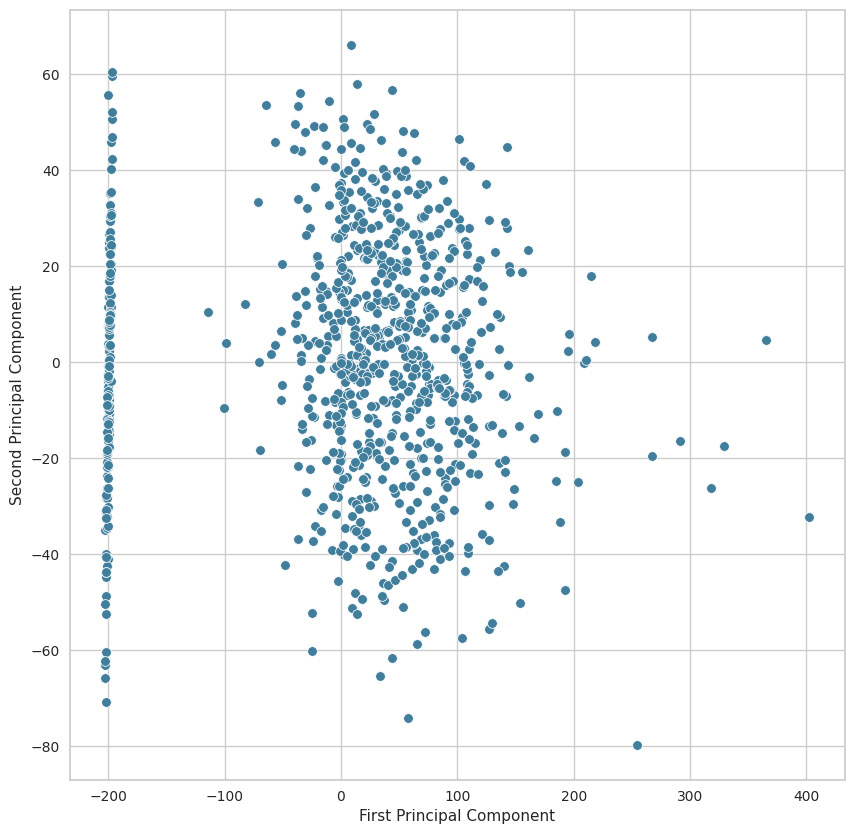

In [28]:
heart_dataset = HeartDiseaseDataset()
heart_dataset.visualize_data()

Podemos ver claramente dois grupos que são linearmente separáveis. Mas vamos lembrar que este é um conjunto de dados dimensionalmente reduzido e o conjunto de dados original tem 13 dimensões. Portanto, fazer quaisquer suposições sobre a separabilidade linear dos dois grupos pode não ser preciso neste momento.

Além disso, não sabemos quantos alvos K precisamos prever. Felizmente, temos algumas estratégias para escolher o número certo de clusters.

## Encontrando o valor de K

Ao trabalhar com problemas de aprendizagem não supervisionada é difícil escolher as métricas corretas para avaliar o desempenho do nosso modelo. Para problemas de agrupamento, podemos usar duas estratégias principais:

- **O Método do Cotovelo**
- **Pontuação da silhueta**

O método do cotovelo é um método gráfico que nos ajuda a escolher o número de clusters, traçando a pontuação de distorção em relação ao número de clusters. A pontuação de distorção é normalmente definida como a soma dos quadrados dentro do cluster (WCSS). Essa pontuação quantifica o quão firmemente os pontos de dados em cada cluster estão agrupados em torno do centróide do cluster. Sua fórmula é:

$$\text{Distorção} = \sum _{i=1}^{K}\sum _{x\in C_i}\|x-\mu _{i}\|^2$$

Onde:
- $K$ é o número de clusters
- $C_i$ é o conjunto de pontos de dados no cluster $i$
- $\mu_i$ é o centróide do cluster $i$
- $x$ é um ponto de dados
- $\|x-\mu_i\|$ é a distância euclidiana entre o ponto de dados $x$ e o centróide $\mu_i$

In [29]:
# Get the data as numpy array
np_heart_dataset = heart_dataset.get_data()

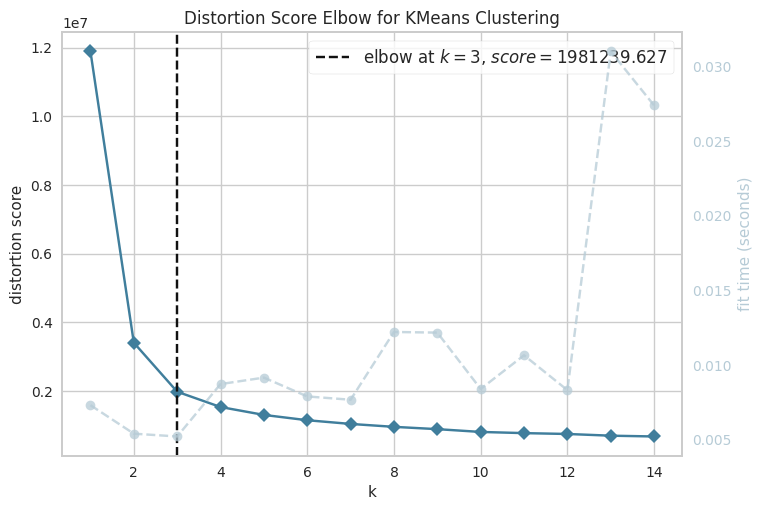

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
model = KMeans(random_state=RANDOM_STATE)
k_elbow = KElbowVisualizer(model, k=(1, 15))
k_elbow.fit(np_heart_dataset)
k_elbow.show()

Parece que o k sugerido pelo método do cotovelo é 3. Porém, visualmente, podemos ver que escolher k=2 pode ser uma escolha melhor.

Além disso, podemos usar o Silhouette Score para validar nossa escolha. O Silhouette Score é uma medida de quão bem cada ponto de dados se ajusta ao cluster atribuído. Varia de -1 a 1, onde um valor próximo de 1 indica um melhor ajuste. Podemos calcular a pontuação do Silhouette para cada cluster e escolher o cluster com a pontuação mais alta.

A fórmula para a pontuação da silhueta é:

$$
s(i) = \frac{b(i) - a(i)}{\max(b(i), a(i))}
$$

Onde:
- $s(i)$ é a pontuação da silhueta para o cluster $ith$
- $a(i)$ é a distância média de todos os pontos do cluster $ith$ ao seu centróide. Isso mede a coesão intra-cluster.
- $b(i)$ é a distância média de todos os pontos no cluster $ith$ até o ponto mais próximo nos outros clusters. Isso mede a separação entre clusters.

Um valor mais próximo de 1 indica que o ponto de dados está bem ajustado ao cluster atribuído, enquanto um valor mais próximo de -1 indica que o ponto de dados está mal ajustado ao cluster atribuído. Um valor 0 indica que o ponto de dados está no limite entre dois clusters.

Vamos visualizar as pontuações da silhueta para $k=2$ e $k=3$:

Silhouette Score: 0.7031


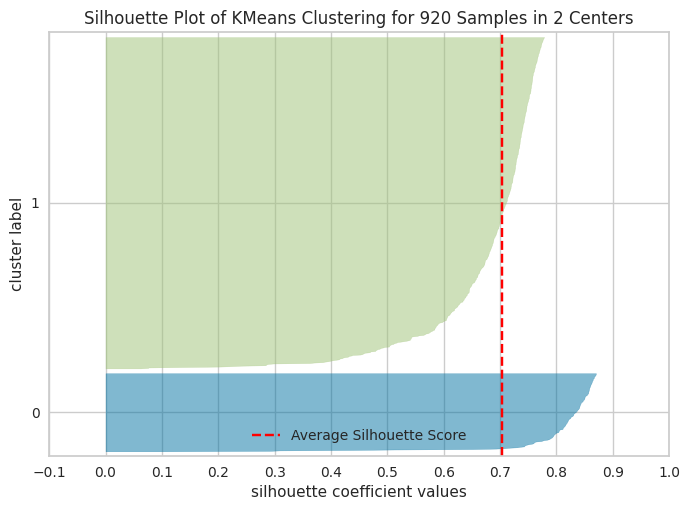

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 920 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [31]:
kmeans_2 = KMeans(n_clusters=2, random_state=RANDOM_STATE)
silhouette_2 = SilhouetteVisualizer(kmeans_2, colors="yellowbrick")
silhouette_2.fit(np_heart_dataset)
score = silhouette_2.silhouette_score_
print(f"Silhouette Score: {score:.4f}")
silhouette_2.show()

Depois de revisar as pontuações da silhueta, podemos concluir que o melhor número para k é 2. A pontuação da silhueta é maior para k=2 do que para k=3, o que significa que os pontos de dados se ajustam melhor aos clusters com k=2.

Silhouette Score: 0.4770


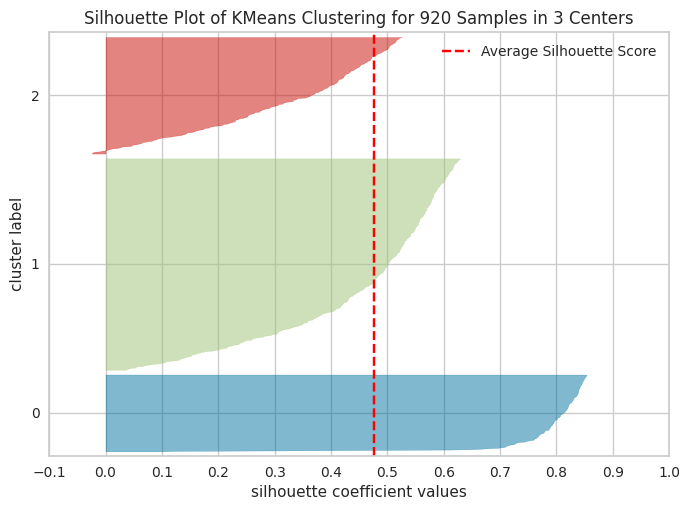

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 920 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
kmeans_3 = KMeans(n_clusters=3, random_state=RANDOM_STATE)
silhouette_3 = SilhouetteVisualizer(kmeans_3, colors="yellowbrick")
silhouette_3.fit(np_heart_dataset)
score = silhouette_3.silhouette_score_
print(f"Silhouette Score: {score:.4f}")
silhouette_3.show()

## Treinando o Modelo

Agora que preparamos o conjunto de dados e escolhemos o número de clusters, podemos iniciar o processo de clustering. Usaremos a classe `KMeans` do `scikit-learn` para realizar o clustering.

Vamos entender a classe `KMeans`. É um algoritmo de clustering que visa particionar os dados em k clusters. O algoritmo começa inicializando aleatoriamente os centros do cluster. Em seguida, ele itera sobre os pontos de dados e atribui cada ponto ao centro do cluster mais próximo. A distância entre o ponto de dados e o centro do cluster é usada para determinar o centro do cluster mais próximo. Este processo continua até que o algoritmo convirja.

K-Means usa o WCSS (soma de quadrados dentro do cluster) ou pontuação de distorção definida acima como função de perda.

Treinaremos o modelo em no máximo 1000 iterações ou até que o modelo convirja.

In [33]:
# Train the model using 3 clusters
model = KMeans(max_iter=1000, n_clusters=2, random_state=RANDOM_STATE)
model.fit(np_heart_dataset)

KMeans(max_iter=1000, n_clusters=2, random_state=1506)

## Fazendo Predições

Depois que o modelo for treinado, podemos usá-lo para fazer previsões no conjunto de dados. Podemos usar o método `predict` da classe `KMeans` para fazer previsões. O método `predict` pega um conjunto de dados como entrada e retorna as atribuições de cluster para cada ponto de dados.

Além disso, podemos visualizar o conjunto de dados reduzido com os clusters atribuídos para validar nossa hipótese de que os dados são linearmente separáveis:

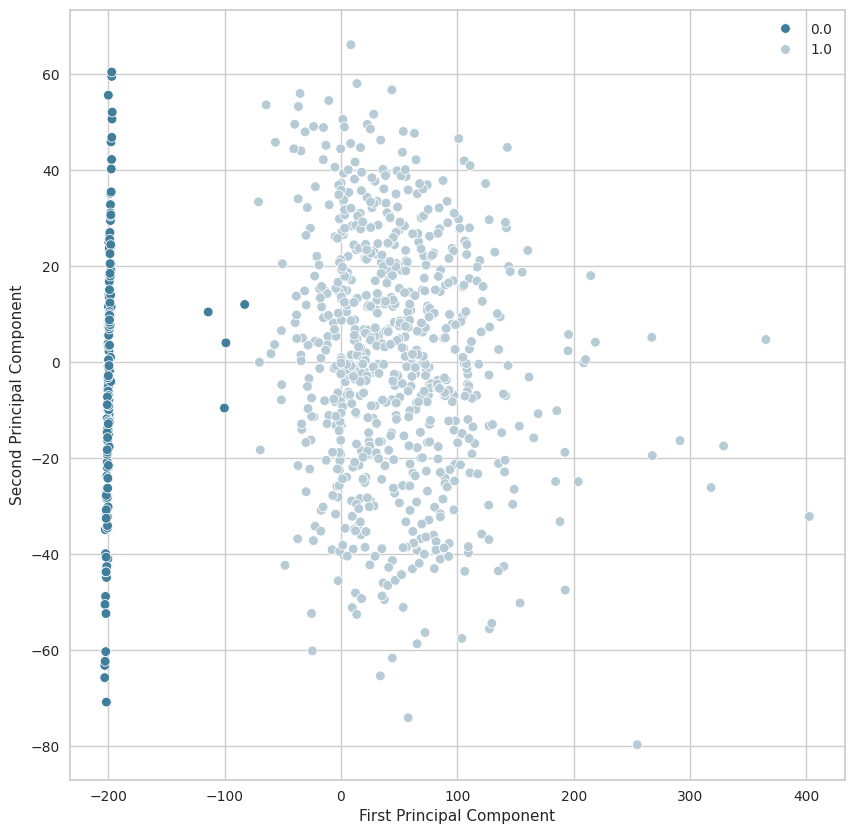

In [34]:
# Make predictions using the model
preds = model.predict(np_heart_dataset)
heart_dataset_2d = heart_dataset.get_ndim_data()
predictions = np.append(heart_dataset_2d, preds[:, None], axis=1)

# Visualize the predictions
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=predictions[:, 0], y=predictions[:, 1], hue=predictions[:, 2])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

Podemos deduzir visualmente o cluster ao qual cada ponto de dados pertence. No entanto, podemos ver que existem alguns pontos no meio que podem estar no cluster errado. A iteração no pré-processamento de dados pode revelar uma estratégia melhor para preencher os valores ausentes.

## Retornando os resultados

Finalmente, podemos usar as previsões feitas para exportar os resultados para um arquivo CSV.

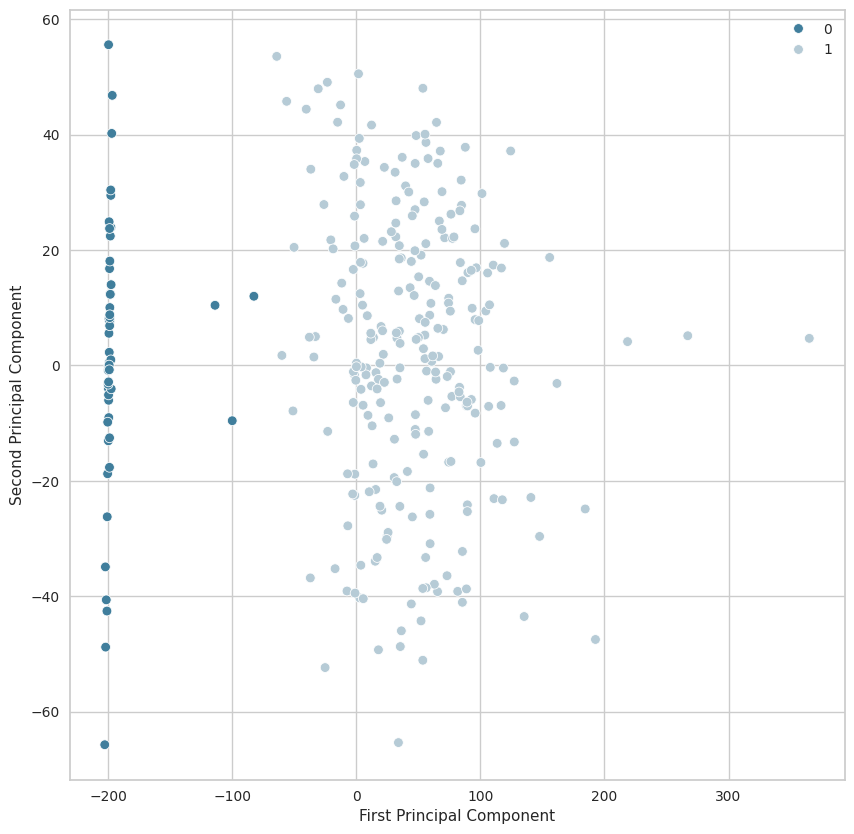

In [35]:
sample_ids = pl.read_csv(HEART_DISEASE_SAMPLE).get_column("id").to_numpy()
sample_preds = [preds[i] for i in sample_ids]
sample_2d_data = heart_dataset_2d[sample_ids]

plt.figure(figsize=(10, 10))
sns.scatterplot(x=sample_2d_data[:, 0], y=sample_2d_data[:, 1], hue=sample_preds)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

In [36]:
pl.DataFrame({"id": sample_ids, "cluster": sample_preds}).write_csv("clustering.csv")

## Conclusões

Trabalhar com dados médicos é uma tarefa desafiadora. Ao tomar decisões sobre o preenchimento de valores ausentes, como codificar as colunas categóricas e escolher o número de clusters, é fácil cometer erros.

É necessário apoiar as nossas decisões não só na documentação, mas também nos resultados e na exploração visual dos dados. Além disso, precisamos validar os resultados dos nossos modelos e entender onde estão as oportunidades de melhoria.

Criar um bom modelo não implica apenas escolher o algoritmo certo, mas também compreender o processo, as limitações e pré-processar o conjunto de dados da melhor forma possível.